In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
import scipy.optimize
import numdifftools as nd
from numdifftools import Jacobian, Hessian

In [2]:
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# BYMARKEDER
#df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/by%20markeder/Bresnahan_data_by.csv")

# KOMMUNEMARKEDER
df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/Bresnahan_data_full_l%C3%A6s%C3%B8.csv")

df = df.drop(['Unnamed: 0'], axis=1)

In [4]:
df

,Kommune,ALDER,d65,d17,samlet_ind,Besk,Besk1864,DK,Befolkning,markedsvaerdix,yderkom,antal_apo,År
0,101,36.10,0.11,0.17,197499.87,0.55,0.73,0.79,518574,2068229.73,0,26,2008
1,147,39.68,0.16,0.17,221333.09,0.54,0.76,0.85,95029,2206108.69,0,5,2008
2,151,40.04,0.18,0.23,186155.49,0.49,0.77,0.88,47398,2432344.50,0,3,2008
3,153,40.57,0.18,0.22,172691.88,0.48,0.73,0.76,33762,1951806.28,0,2,2008
4,155,42.38,0.20,0.23,220357.76,0.51,0.82,0.94,13411,2977526.41,0,1,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,825,51.74,0.35,0.14,154652.82,0.47,0.73,0.93,1795,789854.05,1,0,2014
1074,825,51.80,0.36,0.14,156511.19,0.47,0.74,0.92,1817,547791.16,1,0,2015
1075,825,52.28,0.37,0.13,158750.32,0.47,0.75,0.92,1793,489477.15,1,0,2016
1076,825,52.95,0.38,0.13,165000.49,0.48,0.75,0.91,1807,570316.13,1,0,2017


In [5]:
# df['Befolkning'] betyder at det er på kommuneniveau - er det korrekt?
df['receptgrænse'] = 270000*1.02317**(df['År']-2011)

år = list(range(2008,2019))
# vi har indsat 0 i år efter 2015 for at sikre at disse markeder ikke er restrikteret
gnsrecept = [13.1, 13.12, 13.19, 13.13, 13.24, 13.26, 13.53, 13.13, float("inf") ,float("inf") ,float("inf")]
gnsreceptdic = {}
for i in range(len(gnsrecept)):
    gnsreceptdic[år[i]] = gnsrecept[i]
    
restriction = []

for år in range(2008,2019):
    liste = list((df['Befolkning'][df['År']==år]*gnsreceptdic[år]-df['receptgrænse'][df['År']==år]*df['antal_apo'][df['År']==år])>=df['receptgrænse'][df['År']==år])
    for i in liste:
        restriction.append(i)
        
df['restriction'] = restriction

In [6]:
## FIX YDERKOMMUNER ##
df_komkode_yder = pd.read_excel('kommunerkoderyder.xlsx')
df = df.merge(df_komkode_yder, on = "Kommune")
df  = df.drop('yderkom', axis = 1)
df = df.rename(columns={'Yderkommuner':'yderkom'})

In [7]:
df['yder_mono'] = ((df['antal_apo']<=1)* (df['yderkom']==1))
df['yder_mono'] = df['yder_mono'].astype(int)

C:\Users\Oliver\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [8]:
# KOMMUNER
df['logbefolkning'] = df['Befolkning']/1000#df['By_befolkning']/1000

# BYMARKEDER
#df['logbefolkning'] = df['By_befolkning']/1000#


###
df['logmarkedsvalue'] = df['markedsvaerdix']/100000 #np.log()
df['logindkomst'] = df['samlet_ind']/100000 #np.log()

# Unrestricted markets
#df = df[df['restriction']==True]

In [9]:
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [10]:
def V(df, Ni, alpha=np.ones(5), beta=np.ones(6)):
    """Per-capita variable profit
    
    df: data
    Ni: number of incumbents in market i
    alpha: alpha parameters
    beta: beta parameter
    """
    n = np.min([5, Ni])
#     n = Ni
    a = 0
    for i in range(1,n):
        a = a + alpha[i]
    

    Z = np.c_[df.d65, df.d17, df.logindkomst, df.Besk1864, df.DK, df.yder_mono]# np.log(), 

    # W = df.LANDV
    # X = np.c_[W, Z]

    X = np.c_[Z]
    
    
    profit = alpha[0] + X @ beta - a
    return profit

def F(df, Ni, gamma=np.ones(5)):
    n = np.min([5, Ni])
#     n = Ni
    g = 0
    # gamma 2 through gamma 5 (indices 1 through 4)
    for i in range(1,n):
        g = g + gamma[i]

    fixed_cost = gamma[0] + gamma[5]*df.logmarkedsvalue + g
    return fixed_cost

#def S_func(df, lam):
def S_func(df, lam): #, lam
    S =   lam * df.logbefolkning #np.log() #
    return S


def neg_log_lik(theta=np.ones(18), market='antal_apo', df=df):#, df=None):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:12]
    gamma = theta[12:18]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    Phi = scipy.stats.norm.cdf
    
    S = S_func(df, lam) #, lam

    
    P_U = [0] * 6
    P_R = [0] * 6
    Pi_bar = lambda N: S * V(df, N, alpha=alpha, beta=beta) - F(df, N, gamma=gamma)
    P_U[0] = np.log( 1 - Phi(Pi_bar(0)) )
    P_R[0] = np.log( 1 - Phi(Pi_bar(0)) )    
    P_U[5] = np.log( Phi(Pi_bar(5)) )
    P_R[5] = np.log( Phi(Pi_bar(5)) )
    for i in range(1,5):
        P_U[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )
    for i in range(1,5):
        P_R[i] = np.log( Phi(Pi_bar(i)))
        
    for i in range(6):
        P_U[i][P_U[i] == -np.inf] = -100000000
    for i in range(6):
        P_R[i][P_R[i] == -np.inf] = -100000000
        
        
    log_lik = 0 
    for i in range(5):
        log_lik = log_lik + np.sum(P_R[i] * (df[market] == i) * (df['restriction'] == 0))
    log_lik = log_lik + np.sum(P_R[5] * (df[market] >= 5) * (df['restriction'] == 0))
    for i in range(5):
        log_lik = log_lik + np.sum(P_U[i] * (df[market] == i) * (df['restriction'] == 1))
    log_lik = log_lik + np.sum(P_U[5] * (df[market] >= 5) * (df['restriction'] == 1))

    return -log_lik


def theta_to_param_dict(theta):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:12]
    gamma = theta[12:18]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    d = {'lam': lam, 'beta': beta, 'alpha': alpha, 'gamma': gamma, 'theta': theta} 
    return d

In [11]:
theta0 = np.ones(18) * 0.1
neg_log_lik(df=df, theta=theta0)

1621.1016588652974

In [72]:
df = df.sample(frac=1, random_state = 3).reset_index(drop=True)

In [25]:
df = df.sort_values('antal_apo', ascending = True)
df = df.reset_index(drop=True)

In [26]:
df

,Kommune,ALDER,d65,d17,samlet_ind,Besk,Besk1864,DK,Befolkning,markedsvaerdix,antal_apo,År,receptgrænse,restriction,Navn,yderkom,yder_mono,logbefolkning,logmarkedsvalue,logindkomst
0,825,49.76,0.29,0.16,154148.46,0.48,0.74,0.95,1949,345159.07,0,2010,263885.77,True,Læsø,1,1,1.95,3.45,1.54
1,825,51.80,0.36,0.14,156511.19,0.47,0.74,0.92,1817,547791.16,0,2015,295906.81,True,Læsø,1,1,1.82,5.48,1.57
2,825,48.75,0.27,0.17,161042.72,0.51,0.78,0.95,1993,771991.59,0,2008,252069.54,True,Læsø,1,1,1.99,7.72,1.61
3,825,52.95,0.38,0.13,165000.49,0.48,0.75,0.91,1807,570316.13,0,2017,309777.99,True,Læsø,1,1,1.81,5.70,1.65
4,825,49.35,0.28,0.16,154751.18,0.48,0.74,0.95,1969,524023.91,0,2009,257909.99,True,Læsø,1,1,1.97,5.24,1.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,101,36.10,0.11,0.17,197499.87,0.55,0.73,0.79,518574,2068229.73,26,2008,252069.54,False,København,0,0,518.57,20.68,1.97
1074,101,35.38,0.10,0.18,203077.10,0.54,0.71,0.76,591481,1768450.97,27,2015,295906.81,False,København,0,0,591.48,17.68,2.03
1075,101,35.36,0.10,0.18,213923.14,0.54,0.72,0.76,602481,1984883.50,30,2016,302762.97,False,København,0,0,602.48,19.85,2.14
1076,101,35.39,0.10,0.18,213433.78,0.55,0.73,0.75,613288,2031495.79,33,2017,309777.99,True,København,0,0,613.29,20.31,2.13


In [27]:
%%time
ba = [-np.inf] * 7
bb = [0] * 10
lower_bounds = [*ba, *bb, -np.inf]
upper_bounds = [np.inf] * 18
bounds = list(zip(lower_bounds, upper_bounds))


theta0 = np.ones(18) * 0.1
nll = lambda theta: neg_log_lik(theta=theta, df=df)
out = scipy.optimize.minimize(nll, theta0, bounds=bounds,
    options={'disp': False, 'maxiter': 10000}
    )

Wall time: 5min 55s


In [28]:
out

      fun: 397.2262185882519
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.20887114,  -2.93364906,  -1.22941515, -27.92187956,
       -11.59468752, -13.35134812,   0.62510708, -15.26936444,
        15.89460794,  14.8820277 ,  22.14077881, 121.08985743,
        -0.33210767,   3.33271259,   0.99232693,   1.82633357,
        -0.47915023,   3.26425038])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10203
      nit: 458
   status: 0
  success: True
        x: array([ 1.14290397e+00,  1.07765114e-01,  7.43122774e-02, -1.44639594e-02,
       -2.06619392e-01,  7.08037255e-02, -8.33146446e-01,  1.45828028e+00,
        1.29506778e+00,  8.69677525e-04,  2.33082635e-02,  0.00000000e+00,
        1.76655008e+00,  0.00000000e+00,  1.46221257e+00,  0.00000000e+00,
        8.29460919e-01, -4.81363289e-02])

In [29]:
N = len(df) #Korriger så det passer til antal observationer. 
test = out.hess_inv.todense()/N
se3 = np.sqrt(np.diag(test))
se3

array([1.10868615, 0.43481844, 0.65808609, 0.04517388, 0.22778372,
       0.11838515, 0.33690874, 0.13571217, 0.28174186, 0.09102288,
       0.02732525, 0.03045725, 1.35331701, 0.03045725, 0.73098239,
       0.03045725, 0.5112947 , 0.07412338])

In [30]:
# Hfun = nd.Hessian(nll, full_output=True)
# hessian_nd, info= Hfun(out['x'])
# se = np.sqrt(np.diag(np.linalg.inv(hessian_nd)))
results = pd.DataFrame({'parameters':out['x'], "std err diag":se3})
results.index=['lambda - befolkning','beta_1 - d65','beta_2 - d17','beta_3 - indkomst','beta_4 - besk','beta_5 - Foreigner', 'beta_6 - yderkom' ,'alpha_1','alpha_2','alpha_3','alpha_4','alpha_5','gamma_1','gamma_2','gamma_3','gamma_4','gamma_5', 'gamma_6 - Landvalue'] #,'gamma6' 
results

,parameters,std err diag
lambda - befolkning,1.14,1.11
beta_1 - d65,0.11,0.43
beta_2 - d17,0.07,0.66
beta_3 - indkomst,-0.01,0.05
beta_4 - besk,-0.21,0.23
beta_5 - Foreigner,0.07,0.12
beta_6 - yderkom,-0.83,0.34
alpha_1,1.46,0.14
alpha_2,1.30,0.28
alpha_3,0.00,0.09


In [31]:
hat_theta = theta_to_param_dict(out.x)

In [32]:
def calcS(df, theta):
    d = theta_to_param_dict(theta)
    S_grid = np.zeros(5)
    
    dfm = df.mean()
    for i in range(5):
        n = i + 1
        S_grid[i] = F(dfm, n, d['gamma']) / V(dfm, n, d['alpha'], d['beta'])
        print(F(dfm, n, d['gamma']) )
        print(V(dfm, n, d['alpha'], d['beta']))
    return S_grid

S_vals = calcS(df, out.x)

1.1077116793740642
[1.34503893]
1.1077116793740642
[0.04997115]
2.5699242480387205
[0.04910147]
2.5699242480387205
[0.02579321]
3.3993851672785356
[0.02579321]


In [33]:
S_vals

array([  0.82355362,  22.16702562,  52.33905042,  99.63570723,
       131.79382448])

In [34]:
table5A_left = pd.DataFrame({'Apoteker':S_vals}).T
table5A_left.columns = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5']
table5A_left

,S_1,S_2,S_3,S_4,S_5
Apoteker,0.82,22.17,52.34,99.64,131.79


In [35]:
a = [S_vals[i+1]/S_vals[i] * ((i+1)/(i+2)) for i in range(4)]
table5A_right = pd.DataFrame(a).T
table5A_right.columns = ['s2/s1', 's3/s2', 's4/s3', 's5/s4']

In [36]:
table5A_right

,s2/s1,s3/s2,s4/s3,s5/s4
0,13.46,1.57,1.43,1.06


In [37]:
SN_S5_ratio = S_vals[5-1]* np.arange(1,5+1) / (S_vals * 5)

In [38]:
SN_S5_ratio

array([32.00613075,  2.37819592,  1.51084695,  1.05820556,  1.        ])

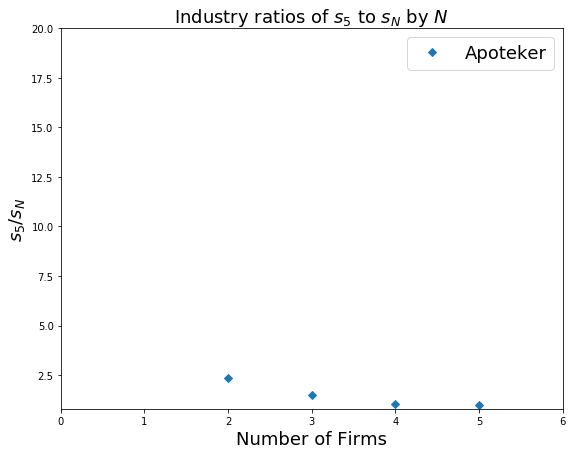

In [39]:
BIG = 18
fig = plt.figure(figsize=(9,7))
plt.plot([1,2,3,4,5], SN_S5_ratio, 'D', label='Apoteker')
ax = fig.get_axes()[0]
plt.legend(fontsize=BIG)
plt.xlim(0,6)
plt.ylim(0.8, 20)
plt.title('Industry ratios of $s_5$ to $s_N$ by $N$', fontsize=BIG)
plt.xlabel('Number of Firms', fontsize=BIG)
plt.ylabel('$s_5/s_N$', fontsize=BIG);
# ax.set_ylabel('$s_5/s_N$', fontsize=40)